In [1]:
import _init_paths

import argparse
import time
import os
import sys
import os.path as osp
from glob import glob

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import caffe
from mpi4py import MPI

from fast_rcnn.test_probe import demo_exfeat
from fast_rcnn.test_gallery import demo_detect
from fast_rcnn.config import cfg, cfg_from_file, cfg_from_list

Set some params
Including model_path and model name

In [2]:
gpu_id = 0
gallery_def = '../models/psdb/resnet50/eval_gallery.prototxt'
probe_def = '../models/psdb/resnet50/eval_probe.prototxt'
caffemodel = '../output/psdb_train/resnet50/resnet50_iter_70000.caffemodel'
det_thresh = 0.75
cfg = '../experiments/cfgs/resnet50.yml'

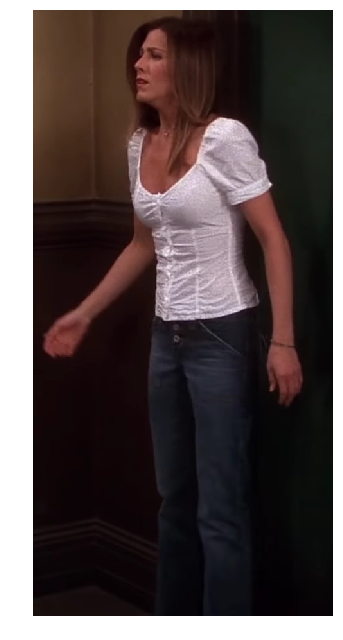

In [3]:
if cfg is not None:
    cfg_from_file(cfg)

# set caffe
caffe.mpi_init()
caffe.set_mode_gpu()
caffe.set_device(gpu_id)

# Get query image and roi
query_img = '../demo/query.jpg'
query_roi = [0, 0, 466, 943]  # [x1, y1, x2, y2]
net = caffe.Net(probe_def, caffemodel, caffe.TEST)
query_feat = demo_exfeat(net, query_img, query_roi)
del net  # Necessary to release cuDNN conv static workspace
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(plt.imread(query_img))
plt.axis('off')
plt.tight_layout()
plt.show()
plt.close(fig)

../demo/gallery-1.jpg ...


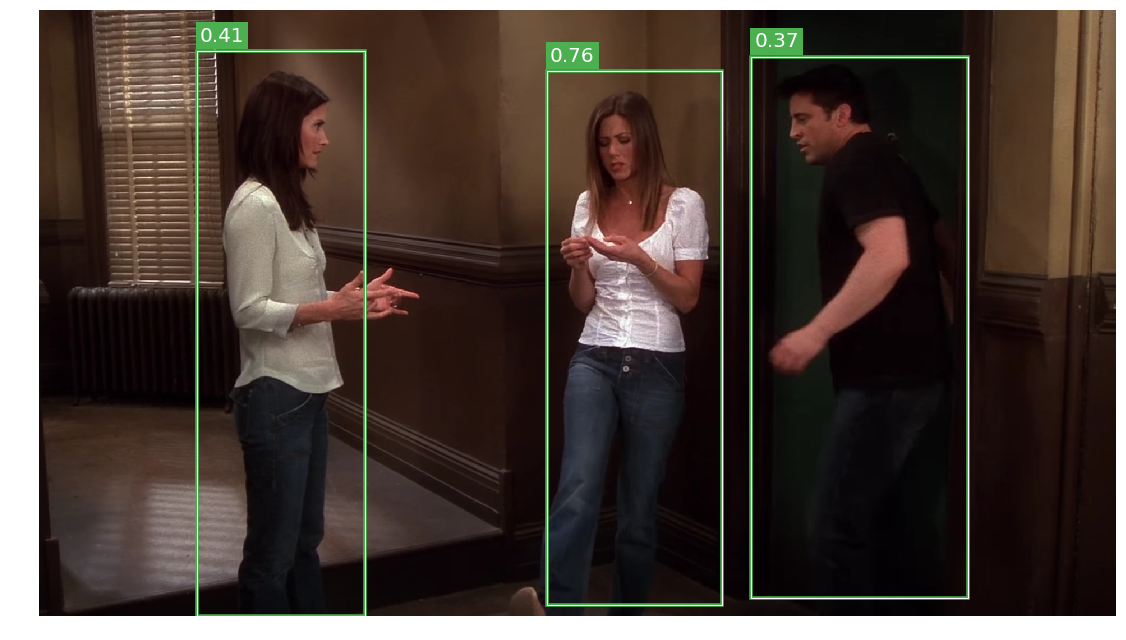

../demo/gallery-2.jpg ...


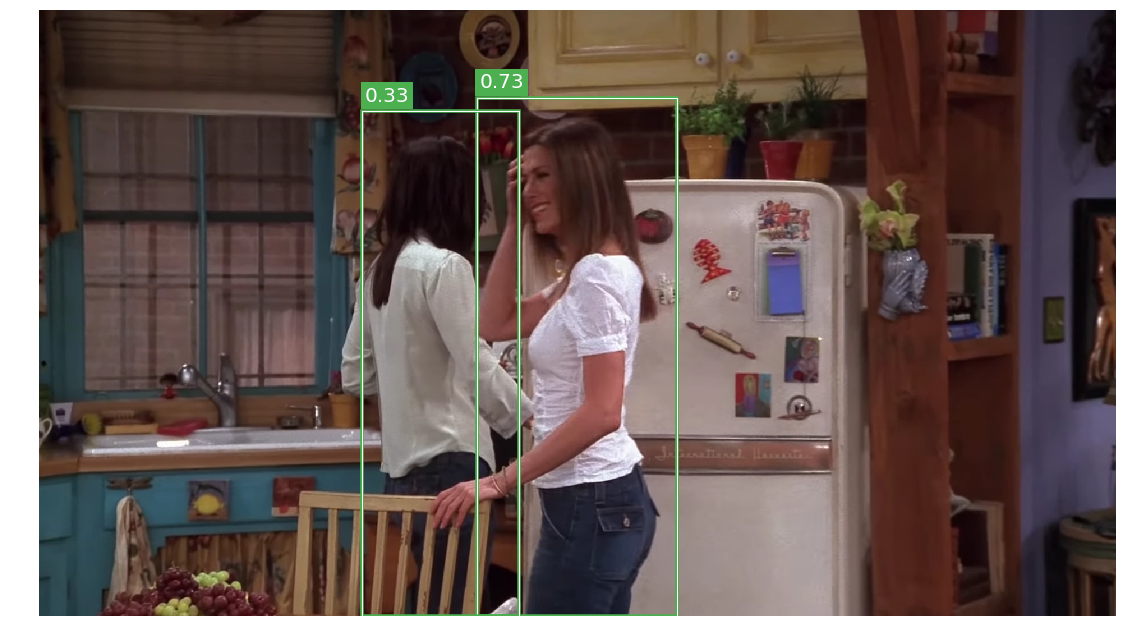

../demo/gallery-3.jpg ...


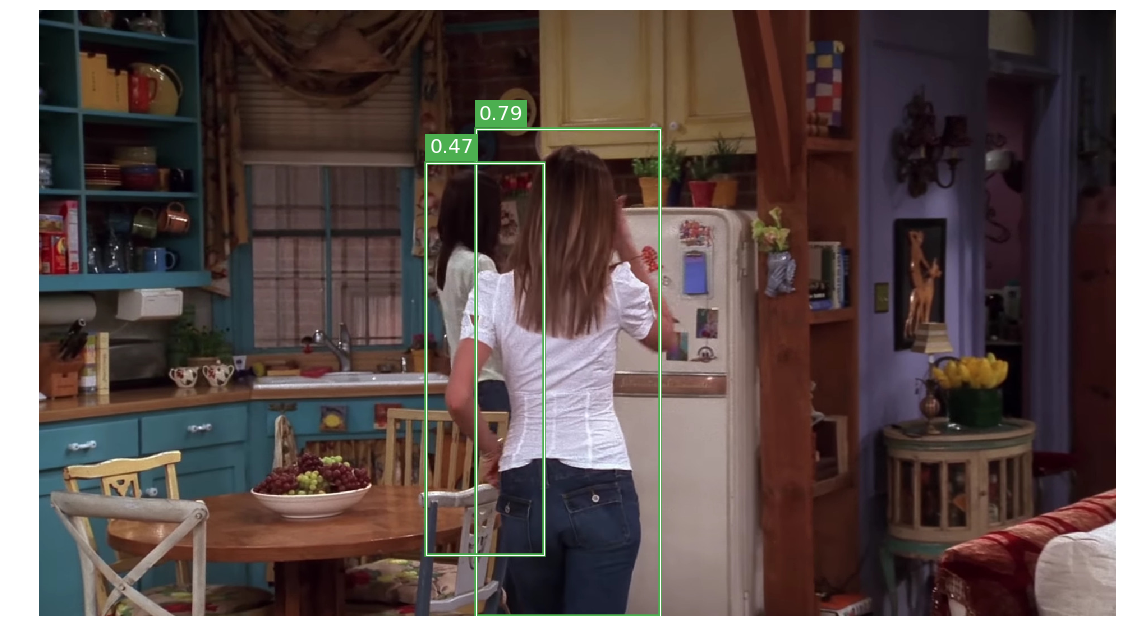

In [4]:
# Get gallery images
gallery_imgs = sorted(glob('../demo/gallery*.jpg'))

# Detect and extract feature of persons in each gallery image
net = caffe.Net(gallery_def, caffemodel, caffe.TEST)

demo_detect(net, query_img)

for gallery_img in gallery_imgs:
    print gallery_img, '...'
    boxes, features = demo_detect(net, gallery_img,
                                    threshold=det_thresh)
    if boxes is None:
        print gallery_img, 'no detections'
        continue
    # Compute pairwise cosine similarities,
    #   equals to inner-products, as features are already L2-normed
    similarities = features.dot(query_feat)

    # Visualize the results
    fig, ax = plt.subplots(figsize=(16, 9))
    ax.imshow(plt.imread(gallery_img))
    plt.axis('off')
    for box, sim in zip(boxes, similarities):
        x1, y1, x2, y2, _ = box
        ax.add_patch(
            plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                            fill=False, edgecolor='#4CAF50', linewidth=3.5))
        ax.add_patch(
            plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                            fill=False, edgecolor='white', linewidth=1))
        ax.text(x1 + 5, y1 - 18, '{:.2f}'.format(sim),
                bbox=dict(facecolor='#4CAF50', linewidth=0),
                fontsize=20, color='white')
    plt.tight_layout()
    plt.show()
    plt.close(fig)
del net